In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(precision=3, suppress=False)
try:
    from scipy.stats import f_oneway
except Exception:
    f_oneway = None

# đọc dữ liệu từ file CSV
df = pd.read_csv('dataset.csv')
if 'Date' in df.columns:
    df = df.drop(columns=['Date'])
target = 'Revenue_(USD)'

## 1. Phân tích các tham số thống kê của dữ liệu

In [93]:
# Kích thước dữ liệu và Thông tin dữ liệu
print("Kích thước dữ liệu:", df.shape)
print("\n🔹 Thông tin dữ liệu:")
print(df.info())

Kích thước dữ liệu: (1132, 15)

🔹 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Average_views_per_viewer  1132 non-null   float64
 1   Unique_viewers            1132 non-null   float64
 2   Click_rate_(%)            1132 non-null   float64
 3   Impressions               1132 non-null   float64
 4   Comments                  1132 non-null   float64
 5   Shares                    1132 non-null   float64
 6   Dislikes                  1132 non-null   float64
 7   Likes                     1132 non-null   float64
 8   Average_viewed_(%)        1132 non-null   float64
 9   Videos_published          1132 non-null   float64
 10  Views                     1132 non-null   float64
 11  Watch_hours               1132 non-null   float64
 12  Average_view_sec          1132 non-null   float64
 13  Revenue_(U

In [94]:
# Thống kê mô tả cơ bản của dữ liệu
print("\n🔹 Thống kê mô tả từng cột:")
display(df.describe().T.round(5))


🔹 Thống kê mô tả từng cột:


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1132.0,1.62723,3.258400e-01,1.0000,1.42695,1.55675,1.79115,2.615800e+00
Unique_viewers,1132.0,25396.72615,5.491041e+04,8.0000,457.50000,4115.00000,18102.50000,4.822540e+05
Click_rate_(%),1132.0,6.56864,2.246660e+00,3.5200,5.16750,6.11000,7.12250,2.314000e+01
Impressions,1132.0,833559.09452,1.878691e+06,44.0000,8469.00000,68862.00000,398580.75000,1.632350e+07
Comments,1132.0,224.11926,7.370135e+02,0.0000,2.00000,28.00000,128.25000,1.158200e+04
Shares,1132.0,123.03622,3.339799e+02,0.0000,2.00000,22.00000,87.00000,6.513000e+03
Dislikes,1132.0,39.39488,8.149386e+01,0.0000,0.75000,6.00000,31.00000,6.640000e+02
Likes,1132.0,2788.84011,7.468639e+03,0.0000,15.00000,257.50000,1246.25000,6.354300e+04
Average_viewed_(%),1132.0,28.77736,6.136640e+00,10.9500,24.22750,28.09500,32.55000,6.219000e+01
Videos_published,1132.0,0.15106,4.598500e-01,0.0000,0.00000,0.00000,0.00000,4.000000e+00


## 2. Chuẩn hóa dữ liệu và đánh giá các thành phần LDA

### 2.1 Với dữ liệu gốc

In [95]:
X = df.drop(columns=[target])
y_cont = pd.to_numeric(df[target], errors='coerce')
num_cols = X.select_dtypes(include=np.number).columns.tolist()
X = X[num_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=num_cols)

print("\n🔹 Dữ liệu sau chuẩn hóa (so với dữ liệu gốc):")
display(X_scaled_df.describe().T.round(5))


🔹 Dữ liệu sau chuẩn hóa (so với dữ liệu gốc):


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1132.0,-0.0,1.00044,-1.92582,-0.61494,-0.21641,0.50328,3.03524
Unique_viewers,1132.0,0.0,1.00044,-0.46257,-0.45438,-0.38774,-0.13290,8.32373
Click_rate_(%),1132.0,-0.0,1.00044,-1.35757,-0.62393,-0.20423,0.24664,7.37927
Impressions,1132.0,0.0,1.00044,-0.44386,-0.43938,-0.40722,-0.23164,8.24872
Comments,1132.0,0.0,1.00044,-0.30423,-0.30151,-0.26622,-0.13014,15.41749
Shares,1132.0,0.0,1.00044,-0.36856,-0.36257,-0.30266,-0.10795,19.14124
Dislikes,1132.0,-0.0,1.00044,-0.48362,-0.47442,-0.40997,-0.10306,7.66783
Likes,1132.0,0.0,1.00044,-0.37357,-0.37156,-0.33908,-0.20663,8.13816
Average_viewed_(%),1132.0,0.0,1.00044,-2.90635,-0.74175,-0.11124,0.61504,5.44718
Videos_published,1132.0,0.0,1.00044,-0.32864,-0.32864,-0.32864,-0.32864,8.37360


In [96]:
#  Tạo nhãn rời rạc từ Revenue theo tertiles: low/mid/high
try:
    y_cls = pd.qcut(y_cont, q=3, labels=['low','mid','high'], duplicates='drop')
except ValueError:
    y_cls = pd.qcut(y_cont.rank(method="first"), q=3, labels=['low','mid','high'])

In [97]:
# Loại hàng bị NaN trong y_cls
mask = y_cls.notna()
X_scaled_masked = X_scaled[mask]
y_cls_masked = y_cls[mask]
n_classes = y_cls_masked.nunique()
n_comp = min(X_scaled_masked.shape[1], n_classes - 1)

In [98]:
lda = LDA(n_components=n_comp, solver='svd')
X_lda = lda.fit_transform(X_scaled_masked, y_cls_masked)
ld_cols = [f'LD{i+1}' for i in range(X_lda.shape[1])]
X_lda_df = pd.DataFrame(X_lda, columns=ld_cols)

print("\n🔹 Tạo DataFrame LDA (dữ liệu gốc, đã chuẩn hoá):")
display(X_lda_df.describe().T.round(5))


🔹 Tạo DataFrame LDA (dữ liệu gốc, đã chuẩn hoá):


,count,mean,std,min,25%,50%,75%,max
LD1,1132.0,0.0,1.98681,-6.84394,-1.43696,0.14618,1.73219,4.55190
LD2,1132.0,0.0,1.10449,-6.02154,-0.45603,0.14107,0.70577,2.04728


#### 2.1.1 Xác định tỉ lệ đóng góp vào khả năng phân biệt lớp


🔹 Tỉ lệ đóng góp vào khả năng phân biệt lớp (LDA discriminative ratio):
LD1: 93.01% | Tích lũy: 93.01%
LD2: 6.99% | Tích lũy: 100.00%
Tổng tỉ lệ (kiểm tra): 1.0000


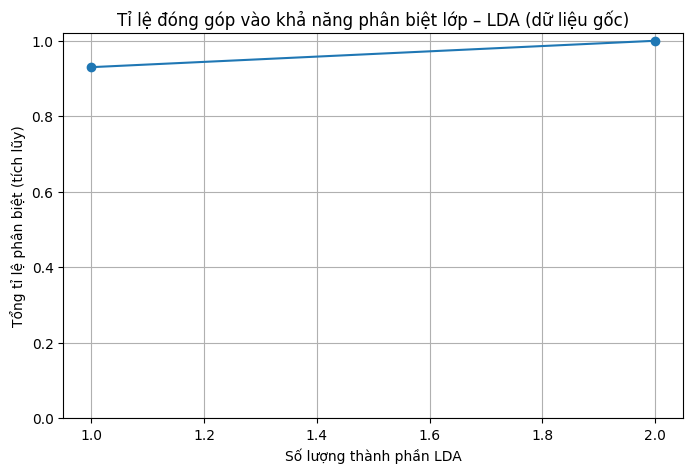

In [99]:
# mức phân biệt của các thành phần LDA
evr = getattr(lda, 'explained_variance_ratio_', None)
if evr is not None:
    cum = np.cumsum(evr)
    print("\n🔹 Tỉ lệ đóng góp vào khả năng phân biệt lớp (LDA discriminative ratio):")
    for i, r in enumerate(evr, 1):
        print(f"LD{i}: {r*100:.2f}% | Tích lũy: {cum[i-1]*100:.2f}%")
    print(f"Tổng tỉ lệ (kiểm tra): {evr.sum():.4f}")

    # Biểu đồ tích lũy
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(cum)+1), cum, marker='o')
    plt.xlabel('Số lượng thành phần LDA')
    plt.ylabel('Tổng tỉ lệ phân biệt (tích lũy)')
    plt.title('Tỉ lệ đóng góp vào khả năng phân biệt lớp – LDA (dữ liệu gốc)')
    plt.ylim(0, 1.02)
    plt.grid(True)
    plt.show()

#### 2.1.2 Phân bố các thành phần LDA theo lớp (Box + Strip)

In [100]:
def plot_ld_distributions(X_ld, y_cls_series, title_prefix="LDA (gốc)"):
    ld_cols = [f"LD{i+1}" for i in range(X_ld.shape[1])]
    df_ld = pd.DataFrame(X_ld, columns=ld_cols)
    df_ld["class"] = y_cls_series.values

    k = min(2, len(ld_cols))                    
    fig, axes = plt.subplots(1, k, figsize=(10, 4), sharey=True)
    if k == 1:
        axes = [axes]                            

    for ax, col in zip(axes, ld_cols[:k]):
        sns.boxplot(data=df_ld, x="class", y=col, ax=ax)
        sns.stripplot(data=df_ld, x="class", y=col, color="0.3", alpha=0.25, size=2, ax=ax)
        ax.set_title(f"{title_prefix} — {col}")
        ax.set_xlabel("Lớp"); ax.set_ylabel(col)

    plt.tight_layout()
    plt.show()


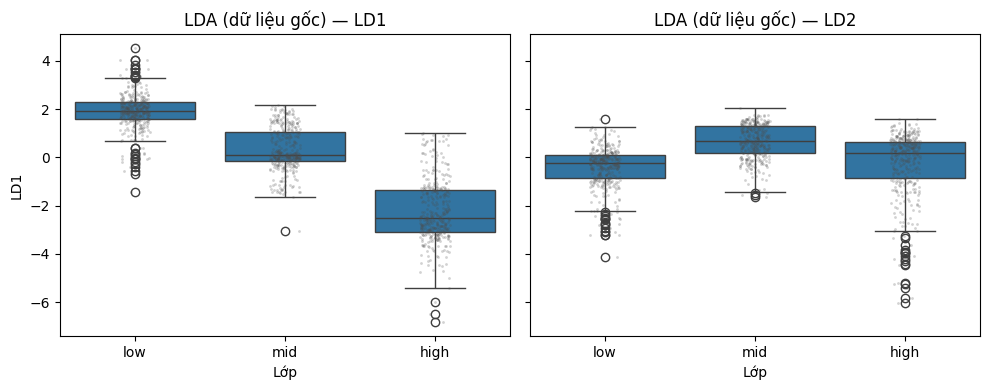

In [101]:
plot_ld_distributions(X_lda, y_cls_masked, title_prefix="LDA (dữ liệu gốc)")

#### 2.1.3 Đánh giá tách lớp: ANOVA (LD ~ class) & η²

In [102]:
def _anova_eta_one_ld(df, ld_col, y_col="class"):
    groups = [df.loc[df[y_col] == c, ld_col].dropna().values
              for c in df[y_col].unique()]

    # One-way ANOVA
    F, p = f_oneway(*groups)

    # Eta-squared
    all_vals = df[ld_col].dropna().values
    grand_mean = np.mean(all_vals)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups if len(g))
    ss_within  = sum(((g - np.mean(g))**2).sum() for g in groups if len(g))
    ss_total   = ss_between + ss_within
    eta_sq = ss_between / ss_total if ss_total > 0 else float("nan")

    return {"LD": ld_col, "F": F, "p_value": p, "eta_sq": eta_sq}

In [103]:
def anova_eta_ld(X_ld, y_cls_series, title_prefix="LDA (gốc)"):
    ld_cols = [f"LD{i+1}" for i in range(X_ld.shape[1])]
    df_ld = pd.DataFrame(X_ld, columns=ld_cols)
    df_ld["class"] = y_cls_series.values

    results = pd.DataFrame([_anova_eta_one_ld(df_ld, col) for col in ld_cols])
    results = results.sort_values("eta_sq", ascending=False).reset_index(drop=True)

    print(f"\n🔹 {title_prefix}: ANOVA (LD ~ class) + η²")
    print(results.round(4))

    # Barplot η²
    plt.figure(figsize=(6,4))
    plt.bar(results["LD"], results["eta_sq"])
    plt.ylabel("η² (eta-squared)")
    plt.title(f"{title_prefix}: Cỡ hiệu ứng tách lớp của các LD")
    plt.ylim(0, 1.0); plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout(); plt.show()

    return results


🔹 LDA (dữ liệu gốc): ANOVA (LD ~ class) + η²
    LD          F  p_value  eta_sq
0  LD1  1667.7572      0.0  0.7471
1  LD2   125.3498      0.0  0.1817


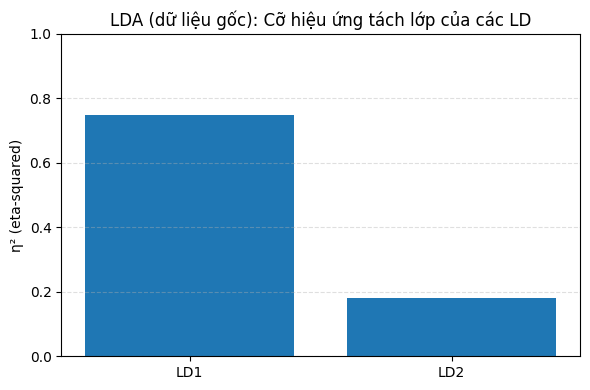

In [104]:
res_lda = anova_eta_ld(X_lda, y_cls_masked, title_prefix="LDA (dữ liệu gốc)")

### 2.2 Với dữ liệu biến đổi logarit

In [105]:
X_log = np.log1p(X)           
scaler_log = StandardScaler()
X_log_scaled = scaler_log.fit_transform(X_log)

print("\n🔹 Dữ liệu sau chuẩn hóa (log1p so với dữ liệu gốc):")
display(pd.DataFrame(X_log_scaled, columns=num_cols).describe().T.round(5))


🔹 Dữ liệu sau chuẩn hóa (log1p so với dữ liệu gốc):


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1132.0,-0.0,1.00044,-2.20621,-0.59789,-0.16481,0.56431,2.71601
Unique_viewers,1132.0,0.0,1.00044,-2.46588,-0.82357,0.09340,0.71227,2.08369
Click_rate_(%),1132.0,-0.0,1.00044,-1.90909,-0.67501,-0.11031,0.41835,4.74357
Impressions,1132.0,0.0,1.00044,-2.65525,-0.73900,0.02769,0.67007,2.02831
Comments,1132.0,0.0,1.00044,-1.42081,-0.93387,0.07168,0.73406,2.72663
Shares,1132.0,-0.0,1.00044,-1.42494,-0.89576,0.08535,0.73168,2.80498
Dislikes,1132.0,0.0,1.00044,-1.16673,-0.88029,-0.09453,0.74289,2.41466
Likes,1132.0,0.0,1.00044,-1.91624,-0.90739,0.10500,0.67765,2.10793
Average_viewed_(%),1132.0,0.0,1.00044,-4.42281,-0.72027,-0.01351,0.69246,3.82964
Videos_published,1132.0,0.0,1.00044,-0.35663,-0.35663,-0.35663,-0.35663,5.69440


In [106]:
# Fit LDA trên bản log
mask2 = y_cls.notna()
lda_log = LDA(n_components=n_comp, solver='svd')
X_log_lda = lda_log.fit_transform(X_log_scaled[mask2], y_cls[mask2])
ld_cols_log = [f'LD{i+1}' for i in range(X_log_lda.shape[1])]
X_log_lda_df = pd.DataFrame(X_log_lda, columns=ld_cols_log)

print("\n🔹 Tạo DataFrame LDA (dữ liệu biến đổi logarit, đã chuẩn hoá):")
display(X_log_lda_df.describe().T.round(5))


🔹 Tạo DataFrame LDA (dữ liệu biến đổi logarit, đã chuẩn hoá):


,count,mean,std,min,25%,50%,75%,max
LD1,1132.0,-0.0,2.61153,-5.76384,-2.18112,-0.20215,2.66493,5.56661
LD2,1132.0,0.0,1.19453,-4.56870,-0.75704,0.10214,0.80209,3.80540


#### 2.2.1 Xác định tỉ lệ đóng góp vào khả năng phân biệt lớp


🔹 Tỉ lệ đóng góp vào khả năng phân biệt lớp (LDA, log1p):
LD1: 93.14% | Tích lũy: 93.14%
LD2: 6.86% | Tích lũy: 100.00%
Tổng tỉ lệ (kiểm tra): 1.0000


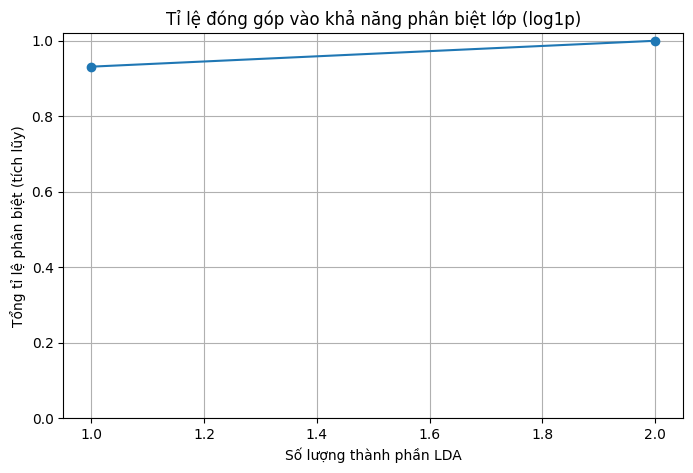

In [107]:
# mức phân biệt của các thành phần LDA (log1p)
evr_log = getattr(lda_log, 'explained_variance_ratio_', None)
if evr_log is not None:
    cum_log = np.cumsum(evr_log)
    print("\n🔹 Tỉ lệ đóng góp vào khả năng phân biệt lớp (LDA, log1p):")
    for i, r in enumerate(evr_log, 1):
        print(f"LD{i}: {r*100:.2f}% | Tích lũy: {cum_log[i-1]*100:.2f}%")
    print(f"Tổng tỉ lệ (kiểm tra): {evr_log.sum():.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(cum_log)+1), cum_log, marker='o')
    plt.xlabel('Số lượng thành phần LDA')
    plt.ylabel('Tổng tỉ lệ phân biệt (tích lũy)')
    plt.title('Tỉ lệ đóng góp vào khả năng phân biệt lớp (log1p)')
    plt.ylim(0, 1.02)
    plt.grid(True)
    plt.show()


#### 2.2.2 Phân bố các thành phần LDA theo lớp (Box + Strip)

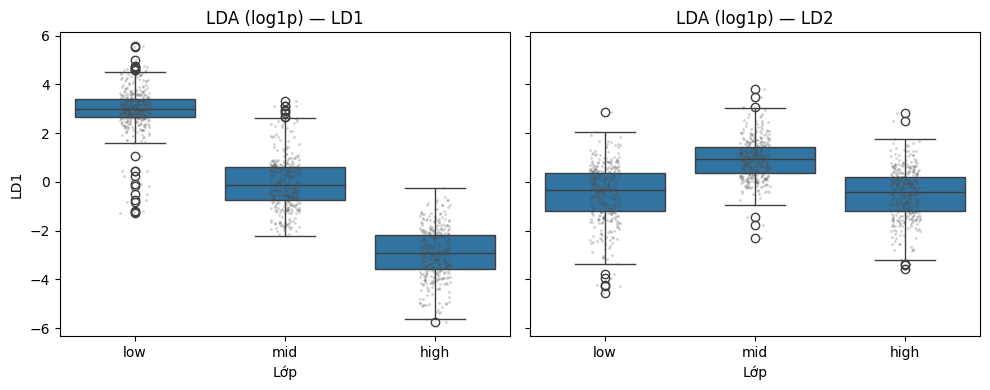

In [108]:
plot_ld_distributions(X_log_lda, y_cls[mask], title_prefix="LDA (log1p)")

### 2.2.3 Đánh giá tách lớp: ANOVA (LD ~ class) & η²


🔹 LDA (log1p): ANOVA (LD ~ class) + η²
    LD          F  p_value  eta_sq
0  LD1  3292.2639      0.0  0.8536
1  LD2   242.4183      0.0  0.3004


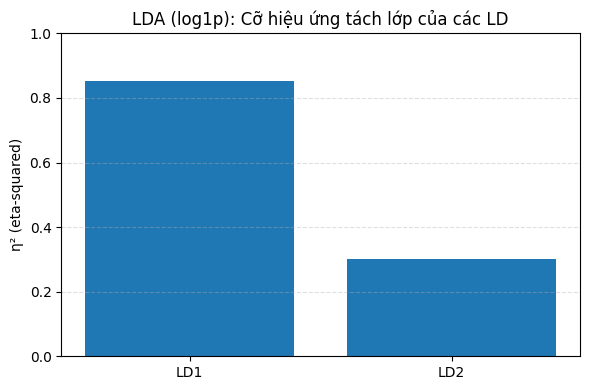

In [109]:
res_lda_log = anova_eta_ld(X_log_lda, y_cls[mask], title_prefix="LDA (log1p)")

### 3.Đánh giá LDA bằng cross-validation

In [110]:
def evaluate_lda_cv(X, y,n_splits=5,use_log=False,regularized=False,random_state=42,title_prefix="LDA (CV)"
):
    
    # Pipeline tiền xử lý và LDA
    log_tf = FunctionTransformer(np.log1p, feature_names_out='one-to-one') if use_log else 'passthrough'
    lda = LDA(solver='lsqr', shrinkage='auto') if regularized else LDA(solver='svd')

    pipe = Pipeline(steps=[
        ('log', log_tf),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('lda', lda)
    ])

    # Stratified KFold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # ACC & F1 
    acc = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy')
    f1m = cross_val_score(pipe, X, y, cv=skf, scoring='f1_macro') 

    # Cross-validated predictions 
    y_pred = cross_val_predict(pipe, X, y, cv=skf)

    labels = sorted(pd.Series(y).dropna().unique().tolist())
    cm = confusion_matrix(y, y_pred, labels=labels)

    print(f"{title_prefix} | folds={n_splits}")
    print(f"Accuracy (mean ± std): {acc.mean():.4f} ± {acc.std():.4f}")
    print(f"F1-macro (mean ± std): {f1m.mean():.4f} ± {f1m.std():.4f}")

    # confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    ax.set_title(title_prefix)
    plt.tight_layout()
    plt.show()

    return {
        "acc_mean": acc.mean(), "acc_std": acc.std(),
        "f1_mean": f1m.mean(), "f1_std": f1m.std(),
        "confusion_matrix": cm, "labels": labels
    }

LDA (original) | folds=5
Accuracy (mean ± std): 0.8083 ± 0.0135
F1-macro (mean ± std): 0.8073 ± 0.0116


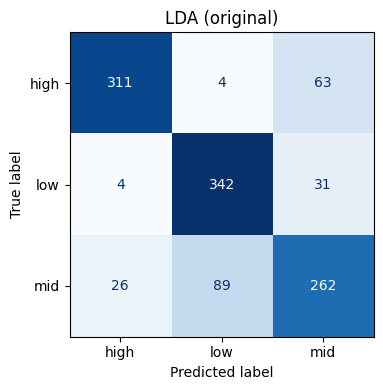

In [111]:
# Đánh giá LDA trên dữ liệu gốc
res_plain = evaluate_lda_cv(X, y_cls, use_log=False, regularized=False, title_prefix="LDA (original)")

LDA (log1p) | folds=5
Accuracy (mean ± std): 0.8913 ± 0.0088
F1-macro (mean ± std): 0.8907 ± 0.0082


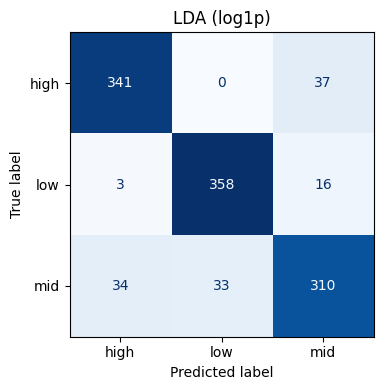

In [112]:
# Đánh giá LDA trên dữ liệu log1p
res_log   = evaluate_lda_cv(X, y_cls, use_log=True,  regularized=False, title_prefix="LDA (log1p)")

## 4.Trực quan hoá 2D theo LDA

In [113]:
def plot_ld_scatter(X_ld, y_cls, title="LDA — LD1 vs LD2"):
    """
    Vẽ scatter 2D theo hai trục phân biệt LD1, LD2.
    - Nếu chỉ có 1 LD (C=2) thì tự động vẽ strip 1D.
    - Tô màu theo lớp, hiển thị tâm cụm (centroid).
    """
    y_codes, y_names = pd.factorize(pd.Series(y_cls).values)

    if X_ld.ndim == 2 and X_ld.shape[1] >= 2:
        fig, ax = plt.subplots(figsize=(7, 6))
        sc = ax.scatter(
            X_ld[:, 0], X_ld[:, 1],
            c=y_codes, alpha=0.6, edgecolors='k', linewidths=0.3
        )
        # Vẽ tâm cụm & nhãn lớp
        for code, name in enumerate(y_names):
            idx = (y_codes == code)
            if np.any(idx):
                mu = X_ld[idx, :2].mean(axis=0)
                ax.scatter(mu[0], mu[1], s=120, marker='X')      
                ax.annotate(str(name), (mu[0], mu[1]), xytext=(6, 6),
                            textcoords='offset points')

        ax.set_xlabel("LD1")
        ax.set_ylabel("LD2")
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

        # Tạo legend thủ công theo tên lớp
        handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                              label=str(n)) for n in y_names]
        ax.legend(handles=handles, title="Class", frameon=True)
        plt.tight_layout()
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(7, 2.4))
        for code, name in enumerate(y_names):
            idx = (y_codes == code)
            ax.scatter(X_ld[idx, 0], np.zeros(idx.sum()),
                       alpha=0.6, edgecolors='k', linewidths=0.3, label=str(name))
        ax.set_xlabel("LD1")
        ax.set_yticks([])
        ax.set_title(title + " (1D)")
        ax.grid(True, alpha=0.3)
        ax.legend(title="Class", frameon=True)
        plt.tight_layout()
        plt.show()


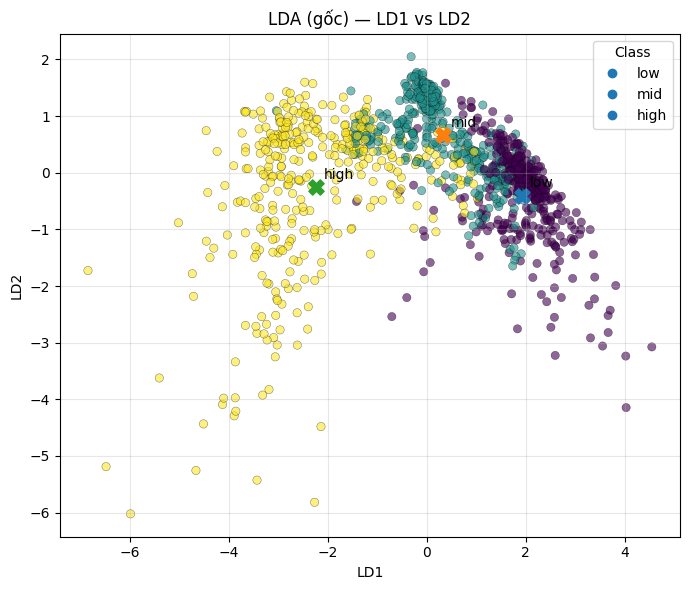

In [114]:
# LDA trên dữ liệu gốc
plot_ld_scatter(X_lda, y_cls_masked, title="LDA (gốc) — LD1 vs LD2")

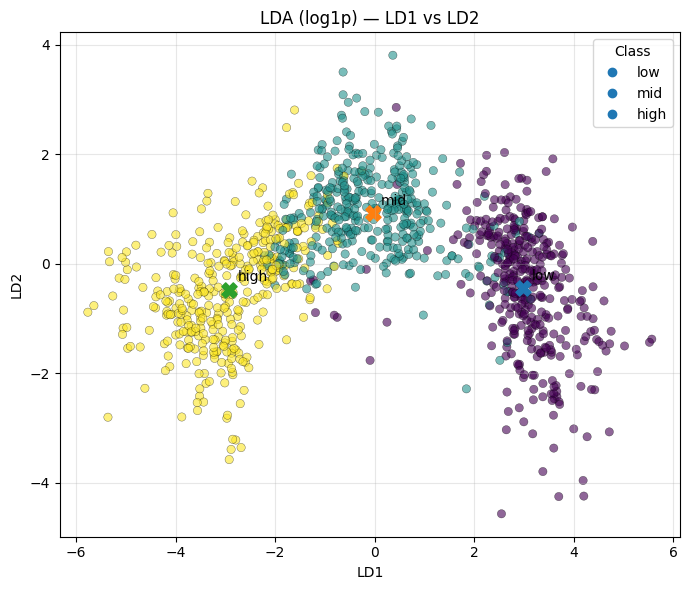

In [115]:
# LDA trên dữ liệu log1p
plot_ld_scatter(X_log_lda, y_cls[mask2], title="LDA (log1p) — LD1 vs LD2")